In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
from utils import *
from scipy import stats
from tqdm.auto import tqdm

c:\Users\Chris\Anaconda3\envs\logistic\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def generate_X(n, d):

    if d != 2:
        raise ValueError("Only d=2 is supported")

    X = np.zeros((n, d))
    X[:,0] = np.random.normal(1.5, 5, n)
    X[:,1] = np.random.exponential(7.6275, n) - 7.6275

    return X

def get_y_prob_bayes_Gaussian(X_m, M, true_beta, n_mc):
    
    unique_patterns = np.unique(M, axis=0)
    
    # Preallocate result array
    prob_y_all = np.zeros((X_m.shape[0],))

    for pattern in unique_patterns:
        # Find indices of rows with this missingness pattern
        pattern_indices = np.all(M == pattern, axis=1)
        X_m_subset = X_m[pattern_indices]
        
        # Directly reuse get_y_prob_bayes_same_pattern for this subset
        prob_y_subset = get_y_prob_bayes_same_pattern_gaussian(X_m_subset, true_beta, n_mc).mean(axis=1)
        
        # Update the results for this pattern
        prob_y_all[pattern_indices] = prob_y_subset
    
    return prob_y_all


def get_y_prob_bayes_same_pattern_gaussian(X_m, true_beta, n_mc):

    m = np.isnan(X_m[0,:])
    n = X_m.shape[0]

    # 1. All observed
    if np.sum(m) == 0:
        logits = np.dot(X_m, true_beta)
        probs = 1 / (1 + np.exp(-logits))
        return probs[:, np.newaxis]  # Still 2D, consistent shape

    # 2. 1st missing
    elif m[0] and not m[1]:
        X2 = X_m[:, 1]
        obs_logits = X2 * true_beta[1]

        mean_probs = np.zeros(n)
        batch_size = 1000  # tune depending on memory
        for _ in tqdm(range(n_mc // batch_size)):
            generated_X1 = np.random.normal(1.5, 5, batch_size)
            logits = obs_logits[:, None] + true_beta[0] * generated_X1
            mean_probs += np.mean(1 / (1 + np.exp(-logits)), axis=1)
        mean_probs /= (n_mc // batch_size)

        return mean_probs[:, np.newaxis]

    # 3. 2nd missing
    elif not m[0] and m[1]:
        X1 = X_m[:, 0]
        obs_logits = X1 * true_beta[0]

        mean_probs = np.zeros(n)
        batch_size = 1000  # tune depending on memory
        for _ in tqdm(range(n_mc // batch_size)):
            generated_X2 = np.random.exponential(7.6275, batch_size) - 7.6275
            logits = obs_logits[:, None] + true_beta[1] * generated_X2
            mean_probs += np.mean(1 / (1 + np.exp(-logits)), axis=1)
        mean_probs /= (n_mc // batch_size)

        return mean_probs[:, np.newaxis]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 77.06it/s]


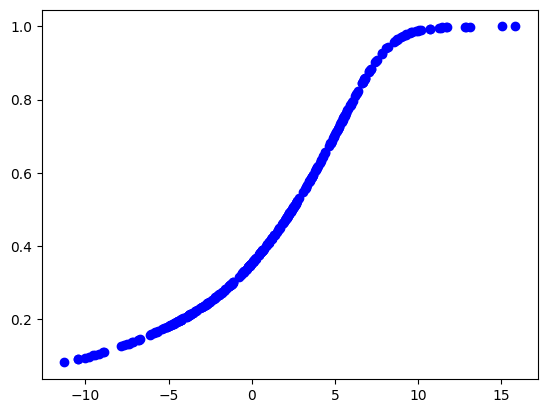

In [3]:
X = generate_X(1000, 2)
M = generate_mask(1000, 2, 0.5)
true_beta = np.array([1, 1])

logits = np.dot(X, true_beta)
probs = 1 / (1 + np.exp(-logits))
y = np.random.binomial(1, probs)

X_m = X.copy()
X_m[M == 1] = np.nan

n_mc = 1000
prob_y_all = get_y_prob_bayes_Gaussian(X_m, M, true_beta, n_mc)

idx = get_index_pattern([0,1], M)
ord = np.argsort(X[:,0][idx])

plt.scatter(X[:,0][idx][ord], prob_y_all[idx][ord], c='blue', label='Observed')

In [ ]:
# Define the percentages of missingness and number of replicates

experiment_name = "ExpG_exponential"
experiment_data_folder = os.path.join("data", experiment_name)

if os.path.exists(experiment_data_folder) == False:
    os.makedirs(experiment_data_folder)

if os.path.exists(os.path.join(experiment_data_folder, "original_data")) == False:
    os.makedirs(os.path.join(experiment_data_folder, "original_data"))

if os.path.exists(os.path.join(experiment_data_folder, "test_data")) == False:
    os.makedirs(os.path.join(experiment_data_folder, "test_data"))

if os.path.exists(os.path.join(experiment_data_folder, "pred_data")) == False:
    os.makedirs(os.path.join(experiment_data_folder, "pred_data"))

if os.path.exists(os.path.join(experiment_data_folder, "bayes_data")) == False:
    os.makedirs(os.path.join(experiment_data_folder, "bayes_data"))


missingness_percentages = [0.50]
n_replicates = 1
Ds = [2]
n_train = 500000
n_test = 15000
n = n_train + n_test


print("# of setups = ", n_replicates * len(missingness_percentages))

N_MC = 10000

# The set-up dataframe should contain:
# - rep
# - n
# - trueProp1
# - true_beta
# - center_X
# - set_up (name)
# [The rest will be part of **kwargs throughout the code]

df_set_up = pd.DataFrame({
    "rep":[],
    "n":[],
    "true_beta": [],
    "set_up": [],
    "d":[],
}).T

# np.random.seed(1)
# random.seed(1)

for rep in range(n_replicates):
    print("REP", rep)
    for d in Ds:

        beta0 = np.array([1,1])

        X_full = generate_X(n, d)
        y_probs = sigma(X_full @ beta0)
        y = np.random.binomial(n=1, p=y_probs)
        
        for prc in missingness_percentages:

            prc_str = str(prc).replace(".", "")
            set_up = f"LOG_n{n}_d{d}_prcNA{prc_str}_rep{rep}"

            M = generate_mask(n, d, prc) # don't allow fully missing
            
            X_obs = X_full.copy()
            X_obs[M == 1] = np.nan


            new_row = pd.Series({
                "rep":rep,
                "n":n,
                "d":d,
                "prcNA":prc,
                "true_beta":beta0,
                "set_up":set_up
            })

            df_set_up = pd.concat([df_set_up, new_row], axis=1, ignore_index=True)

            data_to_save = {
                "X_obs": X_obs,
                "M": M,
                "y": y,
                "y_probs": y_probs,
                "X_full": X_full
            }

            # save
            np.savez(os.path.join(experiment_data_folder, "original_data", f"{set_up}.npz"), **data_to_save)

            # test data
            X_test = X_obs[n_train:]
            y_test = y[n_train:]
            y_probs_test = y_probs[n_train:]
            M_test = M[n_train:]
            data_to_save_test = {
                "X_obs": X_test,
                "M": M_test,
                "y": y_test,
                "y_probs": y_probs_test,
                "X_full": X_full[n_train:]
            }
            np.savez(os.path.join(experiment_data_folder, "test_data", f"{set_up}.npz"), **data_to_save_test)

            y_probs_bayes = get_y_prob_bayes_Gaussian(X_test, M_test, beta0, N_MC)

            data_to_save_bayes = {
                "y_probs_bayes": y_probs_bayes
            }

            np.savez(os.path.join(experiment_data_folder, "bayes_data", f"{set_up}.npz"), **data_to_save_bayes)

                    
# save df set-up
df_set_up.T.to_csv(os.path.join(experiment_data_folder, "set_up.csv"), index=False)

# of setups =  1
REP 0


100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


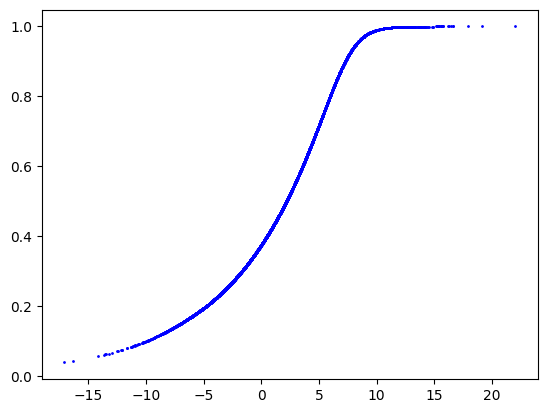

In [5]:
bayes = load_data("LOG_n515000_d2_prcNA05_rep0", "bayes", "ExpG_Exponential")
prob_y_all = bayes["y_probs_bayes"]

test = load_data("LOG_n515000_d2_prcNA05_rep0", "test", "ExpG_Exponential")
X_test = test["X_obs"]
M = test["M"]

idx = get_index_pattern([0,1], M)
ord = np.argsort(X_test[:,0][idx])

plt.scatter(X_test[:,0][idx][ord], prob_y_all[idx][ord], c='blue', label='Observed', s=1)